# Assignment model, by exhaustive optimization.

This code uses very naive optimization. It's good for sanity checking a result, not good for actually running anything.

In [1]:
import numpy as np
import scipy.optimize
import pandas
import collections
import contextlib, io, IPython.display # for some nifty tricks with printout output
import ipyleaflet
import shapefile # for parsing a shapefile into geojson
import branca # for colourmaps
import matplotlib.pyplot as plt

## Dummy data

The rest of the code assumes a network with $V$ nodes and $E$ edges/routes, and a dataframe `routes` with $E$ rows and with columns for

* `demand`, `vehicle_cost`, `bus_price`
* `src`, `dst` (integer indexes in the range $0,\dots,V-1$)

In [2]:
routes = pandas.DataFrame({'src': [0,1], 'dst': [1,0], 'demand': [10.0,2.0], 'vehicle_cost': [1.5,1.5], 'bus_price': [1.0,6.0]})
nodes = pandas.DataFrame({'id': [0,1], 'lat': [37.834,37.802], 'long': [-122.482,-122.461]})

## Data import

In [126]:
# Read in the trip dataset
trips = pandas.read_csv("../data/source_des_with_taxi_and_bus_and_city_and_fuel.csv", sep=',')
trips = trips.drop(['Unnamed: 0'], axis=1)
trips.iloc[:3]

,original_idx,orig_tract,des_tract,orig_lat,orig_long,des_lat,des_long,startime,endtime,mode,hhincome,day,ampm_start,taxi_price,orig_city,des_city,bus_price,fuel_cost,distance,duration
0,665,18000,23300,37.776100,-122.402466,37.723828,-122.398391,825,855,17,6,1,1,11.0,SF,SF,2.750000,2.077387,7072.7,436.1
1,675,18000,23400,37.776100,-122.402466,37.721959,-122.389712,2285,2290,17,6,2,1,14.0,SF,SF,2.750000,2.413856,7976.4,515.5
2,1412,252102,252106,38.092052,-122.109933,38.075442,-122.167755,705,720,40,12,1,0,10.0,Solano County,Solano County,10.833333,2.298146,6785.4,520.1


In [127]:
# Helper function to make it cleaner to call DataFrame.apply
def dict_to_series(f):
    def g(*args, **kwargs):
        d = f(*args, **kwargs)
        k,v = zip(*d.items())
        return pandas.Series(v, index=k)
    return g

@dict_to_series
def aggfunc(df):
    return {'demand': len(df),
            'bus_price': np.mean(df['bus_price']),
            'vehicle_cost': np.mean(df['fuel_cost']), # note: this column already includes driver wage
            'distance': np.mean(df['distance'])
           }

routes = trips.groupby(['orig_tract','des_tract']).apply(aggfunc).reset_index()

# Get a list of all nodes (tracts / locations), with lat+lng.

n1 = trips[['orig_tract','orig_lat','orig_long']] \
    .rename(columns={'orig_tract':'tract', 'orig_lat':'lat', 'orig_long':'long'})
n2 = trips[['des_tract','des_lat','des_long']] \
    .rename(columns={'des_tract':'tract', 'des_lat':'lat', 'des_long':'long'})
n1['dir'] = 1
n2['dir'] = -1

@dict_to_series
def aggfunc(df):
    return {'lat': np.mean(df['lat']),
            'long': np.mean(df['long']),
            'flow_out': np.count_nonzero(df['dir']==1),
            'flow_in': np.count_nonzero(df['dir']==-1)}

nodes = pandas.concat([n1,n2]).groupby('tract').apply(aggfunc).reset_index()
nodes.set_index('tract', inplace=True, drop=False)

# Create route.src and route.dst, with integer indexes
# For the matrix work, we'll want a standard ordering of all nodes, as specified by these indexes.
# To retrieve real-world attributes of the nodes, see nodes[src]

node_index = {n:i for i,n in enumerate(nodes['tract'])}
routes['src'] = [node_index[t] for t in routes['orig_tract']]
routes['dst'] = [node_index[t] for t in routes['des_tract']]

In [128]:
# To speed things up, let's work with a subset of nodes.

(b,l),(t,r) = (37.7545,-122.5137), (37.8109,-122.3753)
nodes['ok'] = (nodes['lat'] >= b) & (nodes['lat'] <= t) & (nodes['long'] >= l) & (nodes['long'] <= r)
routes['ok'] = nodes['ok'].loc[routes['orig_tract']].values & nodes['ok'].loc[routes['des_tract']].values

# If we're not careful, we could end up with an infeasible circulation problem.
# To make sure it's feasible, we'll further require that for every edge i->j there is an edge j->i

rev_routes = pandas.DataFrame({'orig_tract': routes['des_tract'], 'des_tract': routes['orig_tract'], 'reverse_ok': routes['ok']})
rev_routes = rev_routes.loc[rev_routes['reverse_ok']]
routes2 = routes.merge(rev_routes, on=['orig_tract','des_tract'], how='outer')
routes2['reverse_ok'] = ~pandas.isnull(routes2['reverse_ok'])

# Re-index the nodes, so that src and dst only count the nodes we're keeping

nodes = nodes.loc[nodes['ok']]
routes = routes2.loc[routes2['ok'] & routes2['reverse_ok']].copy()
                     
node_index = {n:i for i,n in enumerate(nodes['tract'])}
routes['src'] = [node_index[t] for t in routes['orig_tract']]
routes['dst'] = [node_index[t] for t in routes['des_tract']]

## Network flow optimization (illustration)

Given (a) required passenger flow, (b) cost per unit flow for empty vehicles, find the optimal rebalancing flow.

The circulation constraint is
$$
\sum_k (a_{k i}+\beta_{k i}) = \sum_k (a_{i k}+\beta_{i k}) \quad\text{for all }i
$$
where $a_{i j}$ is the required passenger flow $i\to j$ and $\beta_{i j}$ is the empty vehicle flow. Rewriting this constraint in matrix form,
$$
A . \beta = - A . a
$$
where
$$
A_{i e} = \begin{cases} 1 & \text{if }e=i\to \cdot\\ -1 & \text{if }e=\cdot\to i \\ 0 & \text{else} \end{cases}
$$
The objective is to minimize the rebalancing cost,
$$
\sum_e \beta_{i j} c_{i j}
$$
where $c_{i j}$ is the raw cost for a vehicle to travel $i\to j$.

We'll use `linprog`, to find the optimal rebalancing flow $\beta$.
```
scipy.optimize.linprog(c, A_eq, b_eq, bounds=(0,None), x0=None):
    minimize c @ x
    over x >= 0
    such that A_eq @ x = b_eq
    starting from guess x0
```

In [ ]:
A = np.zeros((len(nodes), len(routes)))
for i,(src,dst) in enumerate(zip(routes['src'], routes['dst'])):
    A[src, i] = 1
    A[dst, i] = -1

In [ ]:
# A has rank |E|-1, because one of the circulation constraints is necessarily redundant.
# Delete an arbitrary row of A, so that scipy doesn't grumble.

res = scipy.optimize.linprog(c = routes['vehicle_cost'], 
                             A_eq = A[:-1], 
                             b_eq = -(A @ routes['demand'])[:-1], 
                             bounds = (0,None),
                             method = 'interior-point',
                             options = {"disp": True, "tol":1e-2, "maxiter":1e4})

Theory says that the true "accounting" cost for rideshare on a link $i\to j$ is
$$
m_{i j} = c_{i j} - \xi_i + \xi_j
$$
where $c_{i j}$ is the cost of running the vehicle, and $\xi_i$ is the dual variable associated with the circulation constraint at node $i$.

```
PRIMAL: minimize c @ x,  over x >= 0,  such that A @ x = b
DUAL:   maximize b @ z,  over z,       such that A.T @ z <= c
```

In [ ]:
dual = scipy.optimize.linprog(c = A @ routes['demand'],
                              A_ub = A.T,
                              b_ub = routes['vehicle_cost'],
                              bounds = (None,None),
                              #method = 'interior-point',
                              options = {"disp": True, "maxiter": 3000})

## Full assignment model

Here we compute the optimal rideshare prices, and hence the optimal fraction of demand that uses rideshare $\alpha$,
as well as the rebalancing flows $\beta$ and the shadow prices $\xi$ at each node. 
For a for-profit rideshare operator, the objective is to choose prices so as to maximize overall profit. For this, we can treat $\alpha$ and $\beta$ as functions of the price, and seek profit-maximizing prices. 
The fundamental relationship is
$$
\text{rideshare_price}_{i j} = \text{vehicle_cost}_{i j} - \xi_i + \xi_j + \text{profit}_{i j}
$$
Hence there are two ways to compute net profit:
$$
\text{net_profit} 
= 
d\alpha\cdot\text{price} - (d\alpha+\beta)\cdot\text{vc}
=
d\alpha\cdot(\text{price}-(\text{vc}+\text{rb}))
$$
where $\text{rb}$ is the rebalancing cost on a route, $\text{rb}_{i j}=\xi_j-\xi_i$.
This fundamental relationship therefore gives us a breakdown of money flows, i.e. a way to 
attribute the rideshare price.

For a non-profit rideshare operator, the objective is to maximize total user utility, subject to collecting enough money to cover operating costs. It would be best to solve this as a global optimization. For the time being, I've implemented this as (1) pick prices, (2) infer $\alpha$, (3) work out the cheapest $\beta$ and shadow prices $\xi$, (4) if the shadow prices tell us that we're not charging enough on a particular route, then bump up the price on that route but don't change $\alpha$: this will result in sub-optimal utility, but it's still a feasible solution. By trying enough prices, we should find one where the loss of utility isn't too great.

<div class="alert alert-warning">
    
TODO: use cvxopt, which (1) is allegedly faster, (2) gives the dual variables.
The problems are straight optimizations with a convex objective and linear constraints,
so they are prime candidates for convex optimization --- no need for gradient descent or
explicit linear sub-problems. [https://cvxopt.org/userguide/solvers.html#problems-with-nonlinear-objectives]

</div>

In [3]:
# Mode choice model, using parameters computed from the trip dataset

CHOICE_BIAS = 1.55393376
CHOICE_RIDESHARE_PRICE = 0.3034984
CHOICE_BUS_PRICE = 0.09368271 

# Dummy model, expressing only price sensitivity
#CHOICE_BIAS = 0
#CHOICE_RIDESHARE_PRICE = 4
#CHOICE_BUS_PRICE = 4

def fraction_rideshare(rideshare_price, bus_price): 
    x = np.exp(CHOICE_BIAS - CHOICE_RIDESHARE_PRICE*rideshare_price + CHOICE_BUS_PRICE*bus_price)
    return x/(1 + x)

def user_utility(rideshare_price, bus_price, fraction_rideshare):
    α = fraction_rideshare
    u_rideshare = CHOICE_BIAS - CHOICE_RIDESHARE_PRICE*rideshare_price
    u_bus = 0 - CHOICE_BUS_PRICE*bus_price
    αsafe = np.where((0<α) & (α<1), α, .5)
    u_choice = np.where((0<α) & (α<1), - αsafe*np.log(αsafe) - (1-αsafe)*np.log(1-αsafe), 0)
    return np.where(fraction_rideshare>0, fraction_rideshare*u_rideshare, 0) + \
           np.where(fraction_rideshare<1, (1-fraction_rideshare)*u_bus, 0) + \
           u_choice

In [4]:
'''Compute the assignment, at a specified rideshare price.

Arguments:
* routes: a DataFrame with one row per route, and columns for src, dst, demand, bus_price, vehicle_cost
* nodes: routes.src and routes.dst should be integers in the range {0,...,len(routes)-1}
* rideshare_price: vector with one entry per route

Return: an Assignment object, which includes the routes DataFrame that was passed in,
as well as several vectors:
* rideshare_price, one entry per route
* fraction_rideshare, one entry per route, values in [0,1]
* rebalancing_flow i.e. β, one entry per route
* shadow_price i.e. ξ, one entry per node
'''

Assignment = collections.namedtuple('Assignment', ['routes','rideshare_price','fraction_rideshare','rebalancing_flow','shadow_price'])

def assignment_at_price(routes, nodes, rideshare_price):
    α = fraction_rideshare(rideshare_price, routes['bus_price'])
    (β,ξ) = _rebalancing_flows(demand = α * routes['demand'], 
                               vehicle_cost = routes['vehicle_cost'], 
                               src = routes['src'], 
                               dst = routes['dst'], 
                               num_nodes = len(nodes))
    return Assignment(routes=routes, rideshare_price=rideshare_price, fraction_rideshare=α, rebalancing_flow=β, shadow_price=ξ)


def _rebalancing_flows(demand, vehicle_cost, src, dst, num_nodes):
    # Given rideshare_demand and vehicle_cost, compute the optimal rebalancing flow β and the corresponding dual variables ξ
    # Build the incidence matrix
    A = np.zeros((num_nodes, len(demand)))
    for i,(s,d) in enumerate(zip(src,dst)):
        A[s,i] = 1
        A[d,i] = -1
    # Solve the primal and dual
    print("PRIMAL")
    res1 = scipy.optimize.linprog(c = vehicle_cost, 
                                  A_eq = A[:-1], 
                                  b_eq = -(A @ demand)[:-1], 
                                  bounds = (0,None),
                                  options = {"disp": True, "tol":1e-2, "maxiter":1e4})
    print("DUAL")
    res2 = scipy.optimize.linprog(c = A @ demand,
                                  A_ub = A.T,
                                  b_ub = vehicle_cost,
                                  bounds = (None,None),
                                  #method = 'interior-point',
                                  options = {"disp": True, "maxiter": 3000})
    return (np.array(res1.x), np.array(res2.x))

In [5]:
'''Compute the optimal assignment, for a for-profit rideshare operator'''

def profit(assignment):
    # For a profit-maximizing enterprise, the goal is to maximize profit = revenue - costs
    d,c = assignment.routes['demand'], assignment.routes['vehicle_cost']
    α,β,π = assignment.fraction_rideshare, assignment.rebalancing_flow, assignment.rideshare_price
    profit = np.sum((d*α*π) - (d*α+β)*c)
    return profit

def assignment_maxprofit(routes, nodes):
    # TODO: use gradient descent to find the profit-maximizing multipliers...
    # Or, since the objective is convex, a straight convex optimizer should work!
    # For now, I'll just sample 100 random surge multipliers and pick the best.
    # The tricks with clear_output and redirect_stdout are to give me useful output for progress/debugging.
    (best_res, max_obj, log) = None, float('-inf'), None
    for i in range(100):
        print(i, end='')
        IPython.display.clear_output(wait=True)
        multiplier = np.random.uniform(low=.5, high=15, size=len(nodes))
        route_multiplier = multiplier[routes['src']]
        # There is definitely a feasible solution with profit=0, where no one takes rideshare. Ensure this is found!
        if i == 0: route_multiplier = float('inf')
        π = route_multiplier * routes['vehicle_cost']
        f = io.StringIO()
        with contextlib.redirect_stdout(f):
            res = assignment_at_price(routes, nodes, π)
        obj = profit(res)
        if obj > max_obj: 
            (best_res, max_obj, log) = (res, obj, f.getvalue())
    print(log)
    return best_res

In [6]:
'''Compute the optimal assignment, for a non-profit rideshare operator'''

def utility(assignment):
    d,bp = assignment.routes['demand'], assignment.routes['bus_price']
    α,π = assignment.fraction_rideshare, assignment.rideshare_price
    utility = np.sum(d*user_utility(π,bp,α))
    return utility

def assignment_maxutility(routes, nodes):
    # TODO: better optimizer
    (best_res, max_obj, log) = None, float('-inf'), None
    for i in range(10):
        multiplier = np.random.uniform(low=.5, high=3, size=len(nodes))
        route_multiplier = multiplier[routes['src']]
        # There is definitely a feasible solution with profit=0, where no one takes rideshare. Ensure this is found!
        if i == 0: route_multiplier = float('inf')
        π = route_multiplier * routes['vehicle_cost']
        for j in range(10):
            print(i*10+j, end='')
            IPython.display.clear_output(wait=True)
            f = io.StringIO()
            with contextlib.redirect_stdout(f):
                res = assignment_at_price(routes, nodes, π)
            ξ = res.shadow_price
            minprice = routes['vehicle_cost'] - ξ[routes['src']] + ξ[routes['dst']]
            res = res._replace(rideshare_price = np.maximum(minprice, res.rideshare_price))
            π = 0.9*π + 0.1*res.rideshare_price
            obj = utility(res)
            if obj > max_obj: 
                (best_res, max_obj, log) = (res, obj, f.getvalue())
    print(log)
    return best_res

In [7]:
res1 = assignment_maxprofit(routes, nodes)

PRIMAL
Optimization terminated successfully.
         Current function value: 3.970452    
         Iterations: 1
DUAL
Optimization terminated successfully.
         Current function value: -3.970452   
         Iterations: 2



In [8]:
res2 = assignment_maxutility(routes, nodes)

PRIMAL
Optimization terminated successfully.
         Current function value: 7.646524    
         Iterations: 1
DUAL
Optimization terminated successfully.
         Current function value: -7.646524   
         Iterations: 2



# Depicting the output

## Aggregate numbers

In [9]:
res_p = assignment_maxprofit(routes, nodes)

PRIMAL
Optimization terminated successfully.
         Current function value: 4.108449    
         Iterations: 1
DUAL
Optimization terminated successfully.
         Current function value: -4.108449   
         Iterations: 2



In [10]:
res_np = assignment_maxutility(routes, nodes)

PRIMAL
Optimization terminated successfully.
         Current function value: 8.294085    
         Iterations: 1
DUAL
Optimization terminated successfully.
         Current function value: -8.294085   
         Iterations: 2



In [11]:
# To illustrate the fundamental relationship:
res = res_p

# We could work out profit in the mundane way, profit = revenue - costs
revenue = res.routes.demand * res.fraction_rideshare * res.rideshare_price
costs = (res.routes.demand * res.fraction_rideshare + res.rebalancing_flow) * res.routes.vehicle_cost
print(f"profit: {np.sum(revenue - costs)}")

# But we're cleverer than that! We've got a breakdown of profit!
rebalancing_cost = res.shadow_price[res.routes.dst] - res.shadow_price[res.routes.src] 
rideshare_profit = res.rideshare_price - (res.routes.vehicle_cost + rebalancing_cost)
print(f"profit: {np.sum(res.routes.demand * res.fraction_rideshare * rideshare_profit)}")

profit: 22.1647280870039
profit: 22.164728087003905


In [170]:
# Compare three worlds:
# A. bus only
# B. bus + non-profit rideshare
# C. bus + for-profit rideshare
#
# Note: in bus+rs the passengers might end up paying more -- 
# but that's because they want to: they like having rideshare!

# Bus-only world
d,bp,vc = routes.demand, routes.bus_price, routes.vehicle_cost
N = sum(d)
rev0 = d * bp
print(f"bus-only: bus revenue = ${np.sum(rev0)} = ${np.sum(rev0)/N} / trip")

# Bus plus rideshare non-profit
α,β = res_np.fraction_rideshare, res_np.rebalancing_flow
Nα = sum(d*α)
rev1 = d*(1-α)*bp
opcost = (d*α+β)*vc
print(f"bus+rs.np: bus revenue = ${np.sum(rev1)} = ${np.sum(rev1)/(N-Nα)}/trip * {(N-Nα)/N} of trips")
print(f"bus+rs.np: rs operating costs = ${np.sum(opcost)} = ${np.sum(opcost)/Nα} / trip * {Nα/N} of trips")

# Bus plus rideshare for-profit
α,β,π,ξ = res_p.fraction_rideshare, res_p.rebalancing_flow, res_p.rideshare_price, res_p.shadow_price
Nα = sum(d*α)
rebalancing_cost = ξ[routes.dst] - ξ[routes.src]
rideshare_profit = π - (vc + rebalancing_cost)

rev1 = d*(1-α)*bp
opcost = (d*α+β)*vc
opcost = d*α*(vc + rebalancing_cost) # equivalent
print(f"bus+rs.p: bus revenue = ${np.sum(rev1)} = ${np.sum(rev1)/(N-Nα)}/trip * {(N-Nα)/N} of trips")
print(f"bus+rs.p: rs operating costs = ${np.sum(opcost)} = ${np.sum(opcost)/Nα} / trip * {Nα/N} of trips")
print(f"bus+rs.p: rs profit = ${np.sum(d*α*rideshare_profit)} = ${np.sum(d*α*rideshare_profit)/Nα} / trip")

bus-only: bus revenue = $930.0606060606062 = $2.7680375180375187 / trip
bus+rs.np: bus revenue = $223.33485729292693 = $2.768080997143009/trip * 0.24012558735188924 of trips
bus+rs.np: rs operating costs = $350.14099596844426 = $1.3713927988357073 / trip * 0.7598744126481107 of trips
bus+rs.p: bus revenue = $608.933245190206 = $2.767761540376743/trip * 0.6547895469073408 of trips
bus+rs.p: rs operating costs = $128.42480073605154 = $1.1071990011690174 / trip * 0.34521045309265924 of trips
bus+rs.p: rs profit = $506.0668210036391 = $4.362994340101137 / trip


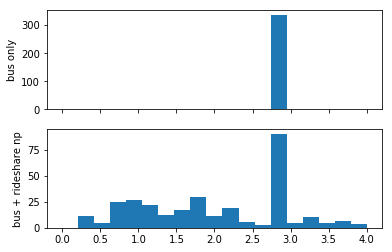

In [171]:
# Look at the distribution of how much people pay in A versus in B/C.
fig,(ax1,ax2) = plt.subplots(2,1, sharex=True)
ax1.hist(bp, weights=d, bins=np.linspace(0,4,20))
ax1.set_ylabel("bus only")
α,π = res_np.fraction_rideshare, res_np.rideshare_price
ax2.hist(list(bp)+list(π), weights=list(d*(1-α))+list(d*α), bins=np.linspace(0,4,20))
ax2.set_ylabel("bus + rideshare np")
plt.show()

## Map dataprep

This section provides some simple high-level commands for assembling plots:

* `geom_choropleth(aes(color=x), ...)` where `x` is a list with one entry per row of `nodes`. The data for this is from the `bayarea_tract2000.shp` shapefile, which has a field for tract ID. We merge it with `nodes['tract']`.

* `geom_network(aes(width=x), ...)` where `x` is a list with one entry per row of `routes`. The data for this is from AA's file `routes.csv`,
which has paths between every pair of tract IDs. We identify the distinct _segments_ in this file, and all the aes attributes are aggregated per segment. (To help with "atomic plots", we also provide a vector `route_length` with one entry per row of `routes`.)

Usage:
```
m = ipyleaflet.Map(center=(37.78, -122.4), zoom=13, layers=[])
m.add_layer(ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.CartoDB.DarkMatter))

g = geom_network(aes(weight=np.maximum(rideshare_profit,0)/route_length*0.3), color='yellow', name='profit')
m.add_layer(g)

g = geom_choropleth(aes(color=nodes['flow_in']), style={'fillOpacity':0.5})
m.add_layer(g)

m.add_control(ipyleaflet.LayersControl())
m
```

<div class="alert alert-warning">
    
TODO: maybe switch to [folium](https://python-visualization.github.io/folium), which seems to be better-documented and 
better-featured. (But I don't think it does the nice split maps.)

</div>

In [172]:
def aes(**kwargs): return kwargs

In [173]:
sf = shapefile.Reader("../data/bayarea_tract2000.shp")
print(sf.fields)

[('DeletionFlag', 'C', 1, 0), ['TRT2000', 'C', 6, 0], ['FIRST_FIPS', 'C', 5, 0], ['FIRST_STFI', 'C', 11, 0], ['FIRST_TRAC', 'C', 10, 0]]


In [174]:
# {tract: geojson_poly, ...}
tract_polygons = {int(r.record[0]): r.shape.__geo_interface__ for r in sf.shapeRecords()}

tracts = {'type': 'FeatureCollection',
          'features': [{'type': 'Feature',
                        'id': i,
                        'properties': {'tract': node.tract},
                        'geometry': tract_polygons[node.tract]}
                      for i,node in enumerate(nodes.itertuples())]
         }

In [175]:
def geom_choropleth(x, **kwargs):
    color_values = x['color']
    del x['color']
    if len(x) > 0:
        badnames = ', '.join(x.keys())
        raise Exception(f"can't plot {badnames}")
    return ipyleaflet.Choropleth(geo_data = tracts, 
                                 choro_data = {i:v for i,v in enumerate(color_values)},
                                 **kwargs)

In [176]:
paths = pandas.read_csv('../data/routes.csv')
paths.sort_values(['origin_tract','des_tract','sequence'], inplace=True)

In [177]:
# For plotting networks, create a dataframe segments with columns [route_num, lng1,lat1, lng2,lat2]
# where route_num is in {0,...,E-1}, i.e. an integer index into routes.
# Also create a vector route_length of length E.

paths['lng2'] = np.append(paths['longitude'][1:].values, np.nan)
paths['lat2'] = np.append(paths['latitude'][1:].values, np.nan)
paths['last'] = np.append(paths['sequence'][1:].values, 0) <= paths['sequence']
segments = paths.loc[~paths['last']].copy()
segments.rename(columns={'longitude':'lng1', 'latitude':'lat1'}, inplace=True)
df = routes[['orig_tract','des_tract']].copy()
df['route_num'] = np.arange(len(df))
segments = segments.merge(df, left_on=['origin_tract','des_tract'], right_on=['orig_tract','des_tract'])
segments['distance'] = np.sqrt(np.power((segments['lng1']-segments['lng2'])*100*np.cos(segments['lat1']*2*np.pi/360),2) + np.power((segments['lat1']-segments['lat2'])*100,2))
df2 = segments.groupby('route_num')['distance'].apply(sum)
route_length = df2.loc[np.arange(len(df))]
route_length.index = routes.index
leftright = (segments['lng1'] < segments['lng2']) | ((segments['lng1'] == segments['lng2']) & (segments['lat1']>=segments['lat2']))
segments['lng1d'] = np.where(leftright,  segments['lng1'], segments['lng2'])
segments['lng2d'] = np.where(~leftright, segments['lng1'], segments['lng2'])
segments['lat1d'] = np.where(leftright,  segments['lat1'], segments['lat2'])
segments['lat2d'] = np.where(~leftright, segments['lat1'], segments['lat2'])
segments = segments.groupby(['lng1d','lng2d','lat1d','lat2d'])['route_num'].apply(list).reset_index()
segments.rename(columns={'lng1d':'lng1', 'lat1d':'lat1', 'lng2d':'lng2', 'lat2d':'lat2'}, inplace=True)

In [178]:
def geom_network(x, name=None, imax=-1, **kwargs):
    if imax<=0: imax=len(segments)
    lines = []
    for seg in segments.iloc[np.arange(imax)].itertuples():
        d = kwargs.copy()
        for k,v in x.items():
            d[k] = sum(v.iloc[r] for r in seg.route_num)
        if 'weight' in d: 
            d['weight'] = int(round(d['weight']))
            if d['weight'] <= 0: continue
        l = ipyleaflet.Polyline(locations=[[[seg.lat1,seg.lng1],[seg.lat2,seg.lng2]]], **d)
        lines.append(l)
    if name is None:
        return ipyleaflet.LayerGroup(layers=lines)
    else:
        return ipyleaflet.LayerGroup(layers=lines, name=name)

## Map output

In [ ]:
# Show the total demand (presumed to go by bus, in the base case)

m = ipyleaflet.Map(center=(37.78, -122.4), zoom=13, layers=[])
m.add_layer(ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.CartoDB.DarkMatter))
m.add_layer(geom_network(aes(weight=res.routes.demand*0.5), color='green', name='bus'))
m

In [ ]:
# Show how it divides between bus and rideshare_np

m = ipyleaflet.Map(center=(37.78, -122.4), zoom=13, layers=[])
m.add_layer(ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.CartoDB.DarkMatter))
m.add_layer(geom_network(aes(weight=res_np.routes.demand*0.5), color='yellow', name='rideshare'))
m.add_layer(geom_network(aes(weight=res_np.routes.demand*(1-res_np.fraction_rideshare)*0.5), color='green', name='bus'))
m

In [ ]:
# And how it divides between bus and rideshare_p

m = ipyleaflet.Map(center=(37.78, -122.4), zoom=13, layers=[])
m.add_layer(ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.CartoDB.DarkMatter))
m.add_layer(geom_network(aes(weight=res_p.routes.demand*0.5), color='yellow', name='rideshare'))
m.add_layer(geom_network(aes(weight=res_p.routes.demand*(1-res_p.fraction_rideshare)*0.5), color='green', name='bus'))
m

In [ ]:
# Where is profit being made by a profiteering rideshare company?
# On which routes is it making a loss?

m = ipyleaflet.Map(center=(37.78, -122.4), zoom=13, layers=[])
m.add_layer(ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.CartoDB.DarkMatter))
g_profit = geom_network(aes(weight=np.maximum(rideshare_profit,0)/route_length*0.3), color='yellow', name='profit')
g_loss = geom_network(aes(weight=-np.minimum(rideshare_profit,0)/route_length*3), color='red', name='loss')
m.add_layer(g_profit)
m.add_layer(g_loss)
m.add_control(ipyleaflet.LayersControl())
m

In [ ]:
# What are the shadow prices, i.e. demand at each location?
# +ve shadow price (red) means there's a surplus of vehicles -- pay extra to go there, get paid to leave from there
# -ve shadow price (blue) means there's a deficit of vehicles -- get paid to go there, pay extra to leave from there

m = ipyleaflet.Map(center=(37.78, -122.4), zoom=13, layers=[])
m.add_layer(ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.CartoDB.DarkMatter))

g = geom_choropleth(aes(color=res.shadow_price), style={'fillOpacity':0.6}, colormap=branca.colormap.linear.PuOr_05, value_min=-4, value_max=4)
m.add_layer(g)

m